In [1]:
from langchain_groq import ChatGroq
from dotenv import load_dotenv
import os
from pprint import pprint
from langchain_core.messages import HumanMessage, AIMessage

groq_api_key  = os.getenv("GROQ_API_KEY")
os.environ["TAVILY_API_KEY"]=os.getenv("TAVILY_API_KEY")

## langsmith Tracing
os.environ["LANGCHAIN_API_KEY"]= os.getenv("LANGCHAIN_API_KEY")
os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_PROJECT"] = "Chatbot With Messages Summarization"

llm = ChatGroq(model_name="meta-llama/llama-4-scout-17b-16e-instruct", groq_api_key=groq_api_key)

In [2]:
from langchain_community.tools import ArxivQueryRun, WikipediaQueryRun
from langchain_community.utilities import ArxivAPIWrapper, WikipediaAPIWrapper

In [3]:
api_wrapper_arxiv = ArxivAPIWrapper(top_k_results=2, doc_content_chars_max=500)
arxiv = ArxivQueryRun(api_wrapper=api_wrapper_arxiv)

api_wrapper_wiki = WikipediaAPIWrapper(top_k_results=2, doc_content_chars_max=400)
wiki = WikipediaQueryRun(api_wrapper=api_wrapper_wiki)

print(arxiv.name, "--",wiki.name)

arxiv -- wikipedia


In [4]:
from langchain_community.tools.tavily_search import TavilySearchResults

tavily = TavilySearchResults(max_results=3)

### Custom tool

In [5]:
def add(a: int, b: int):
    """This is a function which can sum two integer number. first parameter is a, and second parameter is b. return also integer number"""
    
    return a + b

## **Combine all tools**

In [6]:
tools = [arxiv, wiki, tavily, add]

In [7]:
llm_with_tools = llm.bind_tools(tools)

In [8]:
from langchain_core.messages import HumanMessage

llm_with_tools.invoke(
    [HumanMessage(content="Can you add tow number which is 4 and 6")]
).tool_calls

[{'name': 'add',
  'args': {'a': 4, 'b': 6},
  'id': 'call_ypnd',
  'type': 'tool_call'}]

## Now define the Calling Node and State as MessagesState

In [9]:
from langgraph.graph import MessagesState
def tool_calling_llm(state: MessagesState):
    """This function is responsible for response user query or call the tools node based on the query."""
    
    messages = state['messages']
    response = llm_with_tools.invoke(messages)
    return {
        'messages': response
    }

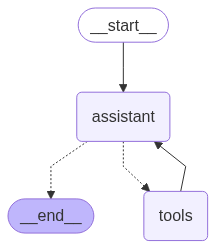

In [10]:
from langgraph.graph import StateGraph, START, END
from langgraph.checkpoint.memory import MemorySaver
from IPython.display import Image, display
from langgraph.prebuilt import ToolNode, tools_condition

builder = StateGraph(MessagesState)

builder.add_node("assistant", tool_calling_llm)
builder.add_node('tools', ToolNode(tools))

builder.add_edge(START, "assistant")
builder.add_conditional_edges(
    'assistant',
    # if the latest messages (result) from the assistant is a tool call --> tools_condition routes to tools.
    # if the latest messages (result) from assistant is not a tool call --> tools_condition routes to END.
    tools_condition,
    
)
builder.add_edge('tools', 'assistant')

memory = MemorySaver()

graph = builder.compile(checkpointer=memory)

## display
display(Image(graph.get_graph().draw_mermaid_png()))

In [11]:
config = {"configurable": {"thread_id": "1"}}

response = graph.invoke(
    {
        'messages': "Can you tell me about the attention all you need research paper"
    },
    config=config
)

for m in response['messages']:
    m.pretty_print()

================================ Human Message =================================

Can you tell me about the attention all you need research paper
================================== Ai Message ==================================
Tool Calls:
  arxiv (call_ctt1)
 Call ID: call_ctt1
  Args:
    query: attention all you need research paper
================================= Tool Message =================================
Name: arxiv

Published: 2023-03-02
Title: Methods used in nanostructure modeling
Authors: I. Camps
Summary: How many times you need to change your method description because you were
"accused" of plagiarism from text you already published? I will use this
preprint to add all the methods I currently used in running the simulations for
my research works. Then, I will cite it as needed.

Published: 2022-07-05
Title: Betti numbers of attention graphs is all you really need
Authors: Laida Kushnareva, Dmitri Piont
================================== Ai Message =======================

In [12]:
config = {"configurable": {"thread_id": "1"}}

response = graph.invoke(
    {
        'messages': "Can you add 3 and 6 and multiply with 10."
    },
    config=config
)

for m in response['messages']:
    m.pretty_print()

================================ Human Message =================================

Can you tell me about the attention all you need research paper
================================== Ai Message ==================================
Tool Calls:
  arxiv (call_ctt1)
 Call ID: call_ctt1
  Args:
    query: attention all you need research paper
================================= Tool Message =================================
Name: arxiv

Published: 2023-03-02
Title: Methods used in nanostructure modeling
Authors: I. Camps
Summary: How many times you need to change your method description because you were
"accused" of plagiarism from text you already published? I will use this
preprint to add all the methods I currently used in running the simulations for
my research works. Then, I will cite it as needed.

Published: 2022-07-05
Title: Betti numbers of attention graphs is all you really need
Authors: Laida Kushnareva, Dmitri Piont
================================== Ai Message =======================

#### in above i do not have multiply tools that is way its make some tools error but llm handel the error.

In [ ]:
config = {"configurable": {"thread_id": "1"}}

response = graph.invoke(
    {
        'messages': "Who is the PM of Bangladesh?"
    },
    config=config
)



AttributeError: 'tuple' object has no attribute 'pretty_print'

In [16]:
for m in response['messages']:
    m.pretty_print()

================================ Human Message =================================

Can you tell me about the attention all you need research paper
================================== Ai Message ==================================
Tool Calls:
  arxiv (call_ctt1)
 Call ID: call_ctt1
  Args:
    query: attention all you need research paper
================================= Tool Message =================================
Name: arxiv

Published: 2023-03-02
Title: Methods used in nanostructure modeling
Authors: I. Camps
Summary: How many times you need to change your method description because you were
"accused" of plagiarism from text you already published? I will use this
preprint to add all the methods I currently used in running the simulations for
my research works. Then, I will cite it as needed.

Published: 2022-07-05
Title: Betti numbers of attention graphs is all you really need
Authors: Laida Kushnareva, Dmitri Piont
================================== Ai Message =======================

In [18]:
input_messages = [HumanMessage(content="What is machine learning?")]
for chunk in graph.stream({'messages': input_messages}, config=config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

What is machine learning?
================================== Ai Message ==================================
Tool Calls:
  wikipedia (call_96ar)
 Call ID: call_96ar
  Args:
    query: machine learning
================================= Tool Message =================================
Name: wikipedia

Page: Machine learning
Summary: Machine learning (ML) is a field of study in artificial intelligence concerned with the development and study of statistical algorithms that can learn from data and generalise to unseen data, and thus perform tasks without explicit instructions. Within a subdiscipline in machine learning, advances in the field of deep learning have allowed neural networks, a class o
================================== Ai Message ==================================

Machine learning (ML) is a field of study in artificial intelligence concerned with the development and study of statistical algorithms th

In [20]:
input_messages = [HumanMessage(content="can you tell why should i learn this?")]
for chunk in graph.stream({'messages': input_messages}, config=config, stream_mode="updates"):
    # chunk["messages"][-1].pretty_print()
    print(chunk)

{'assistant': {'messages': AIMessage(content='Learning machine learning can be beneficial for several reasons:\n\n1. **Career opportunities**: Machine learning is a highly sought-after skill in the industry, and having expertise in this area can open up a wide range of job opportunities in fields like data science, artificial intelligence, and software engineering.\n2. **Problem-solving**: Machine learning enables you to tackle complex problems that are difficult to solve using traditional programming techniques. By learning machine learning, you can develop skills to approach problems in a more data-driven and analytical way.\n3. **Data analysis**: Machine learning provides a powerful toolset for analyzing and interpreting data. By learning machine learning, you can gain insights into data and make informed decisions.\n4. **Automation**: Machine learning can automate many tasks, freeing up time for more strategic and creative work. By learning machine learning, you can automate tasks 

In [21]:
input_messages = [HumanMessage(content="I want to learn Agentic ai so this topics will be help me or not?")]
for chunk in graph.stream({'messages': input_messages}, config=config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()
    # print(chunk)

================================ Human Message =================================

I want to learn Agentic ai so this topics will be help me or not?
================================== Ai Message ==================================

Learning Agentic AI is a fascinating field! Agentic AI refers to AI systems that can act autonomously, make decisions, and take actions on behalf of humans. While machine learning is a fundamental component of Agentic AI, there are other topics that can help you learn Agentic AI. Here's how machine learning and related topics can help:

1. **Machine Learning**: Machine learning is a crucial aspect of Agentic AI, as it enables AI systems to learn from data and improve their performance over time. Understanding machine learning concepts, such as supervised and unsupervised learning, deep learning, and reinforcement learning, will help you build a strong foundation in Agentic AI.
2. **Deep Learning**: Deep learning is a subset of machine learning that involves us